In [10]:
import sys, time, cProfile, pstats, itertools#, tikzplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})

%load_ext autoreload
%autoreload 2

from Database import *
from Densities import *
from MultiIndex import *
from Surrogates import *
from Transport import *
from Forward import *

import plotutil, randutil

query_gauss = """
select {}
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussianposteriordbo as tar 
    on sur.target_id = tar.id
   and sur.target = 'posterior'
  join {} as mul
    on sur.multis_id = mul.id
  join forwarddbo as fwd
    on tar.forwd_id = fwd.id
 where fwd.dim = {}
   and fwd.noise = {}
   and fwd.alpha = {}
   and fwd.basis = '{}'
   and sur.method = '{}'
   and tar.xeval = '{}'
"""
#query_gauss.format('tar.id, mul.size, evl.l2dist', 'multiindexsetanisotropicdbo', 1)

def plot_convergence(*, method='ip_leja', ds=[5,10,20,40,80], alphas=[3,5], noises=[.5, 1], basis='hats', dist='l2dist', mins={}, xeval=np.linspace(-1,1,101), verbose=False) :

    for d in ds : 
        if d not in mins.keys() : mins[d] = 3

    fig = plt.figure(figsize=(20*max(2,len(noises)), 9.*len(alphas)))

    x = np.array([i*base for base in [1, 10, 100] for i in range(1,10)], dtype=float)
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for j, alpha in enumerate(alphas) :
        for k, noise in enumerate(noises) :
            ax = plotutil.get_ax(fig, len(noises), j*len(noises) + k + 1, ny=len(alphas), 
                                 xlabel=r'$|\Lambda|$', title=r'$\sigma=$'+str(noise)+r', $\alpha=$'+str(alpha), logaxis=['x', 'y'])
            for (i, d) in enumerate(ds) :
                q = query_gauss.format('tar.id, mul.size, evl.'+dist, 'multiindexsetanisotropicdbo', d, noise, alpha, basis, method, to_string(xeval))
                #print(q)
                cursor = DB.execute_sql(q)
                col_names = [col[0] for col in cursor.description] 
                res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
                res2 = dict()
                for gk, g in itertools.groupby(res, lambda x : x['id']) :
                    #print(gk)
                    data = np.array([[r['size'], r[dist]] for r in sorted(g, key=lambda x :  x['size']) if r['size'] >= mins[d] and r[dist] is not None])
                    try :
                        if len(data) > 0 :
                            plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.2)
                    except IndexError :
                        print(d, data)

                    for da in data :
                        if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
                        else : res2[da[0]].append(da[1])

                if res2 :
                    keys = [k for k in sorted(res2.keys())]
                    if verbose : print(noise, alpha, [len(res2[k]) for k in keys])
                    mean = [np.mean(res2[k]) for k in keys]
                    minm = [np.min(res2[k]) for k in keys]
                    maxm = [np.max(res2[k]) for k in keys]
                    ax.plot(keys, mean, c=cycle[i], lw=4, label=str(d))
                    ax.fill_between(keys, minm, maxm, color=cycle[i], alpha=.05)
            ax.plot(x[3:], .1*x[3:]**(-alpha+.5), 'k--', label=r'$|\Lambda|^{-\alpha+1}$')
            #ax.plot(x[3:], np.exp(-6.5*np.power(x[3:],1/4)), 'k--', label=r'$exp(-|\Lambda|)$')
            #ax.set_ylim(bottom=5e-4)
            ax.legend()
    plt.tight_layout()
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


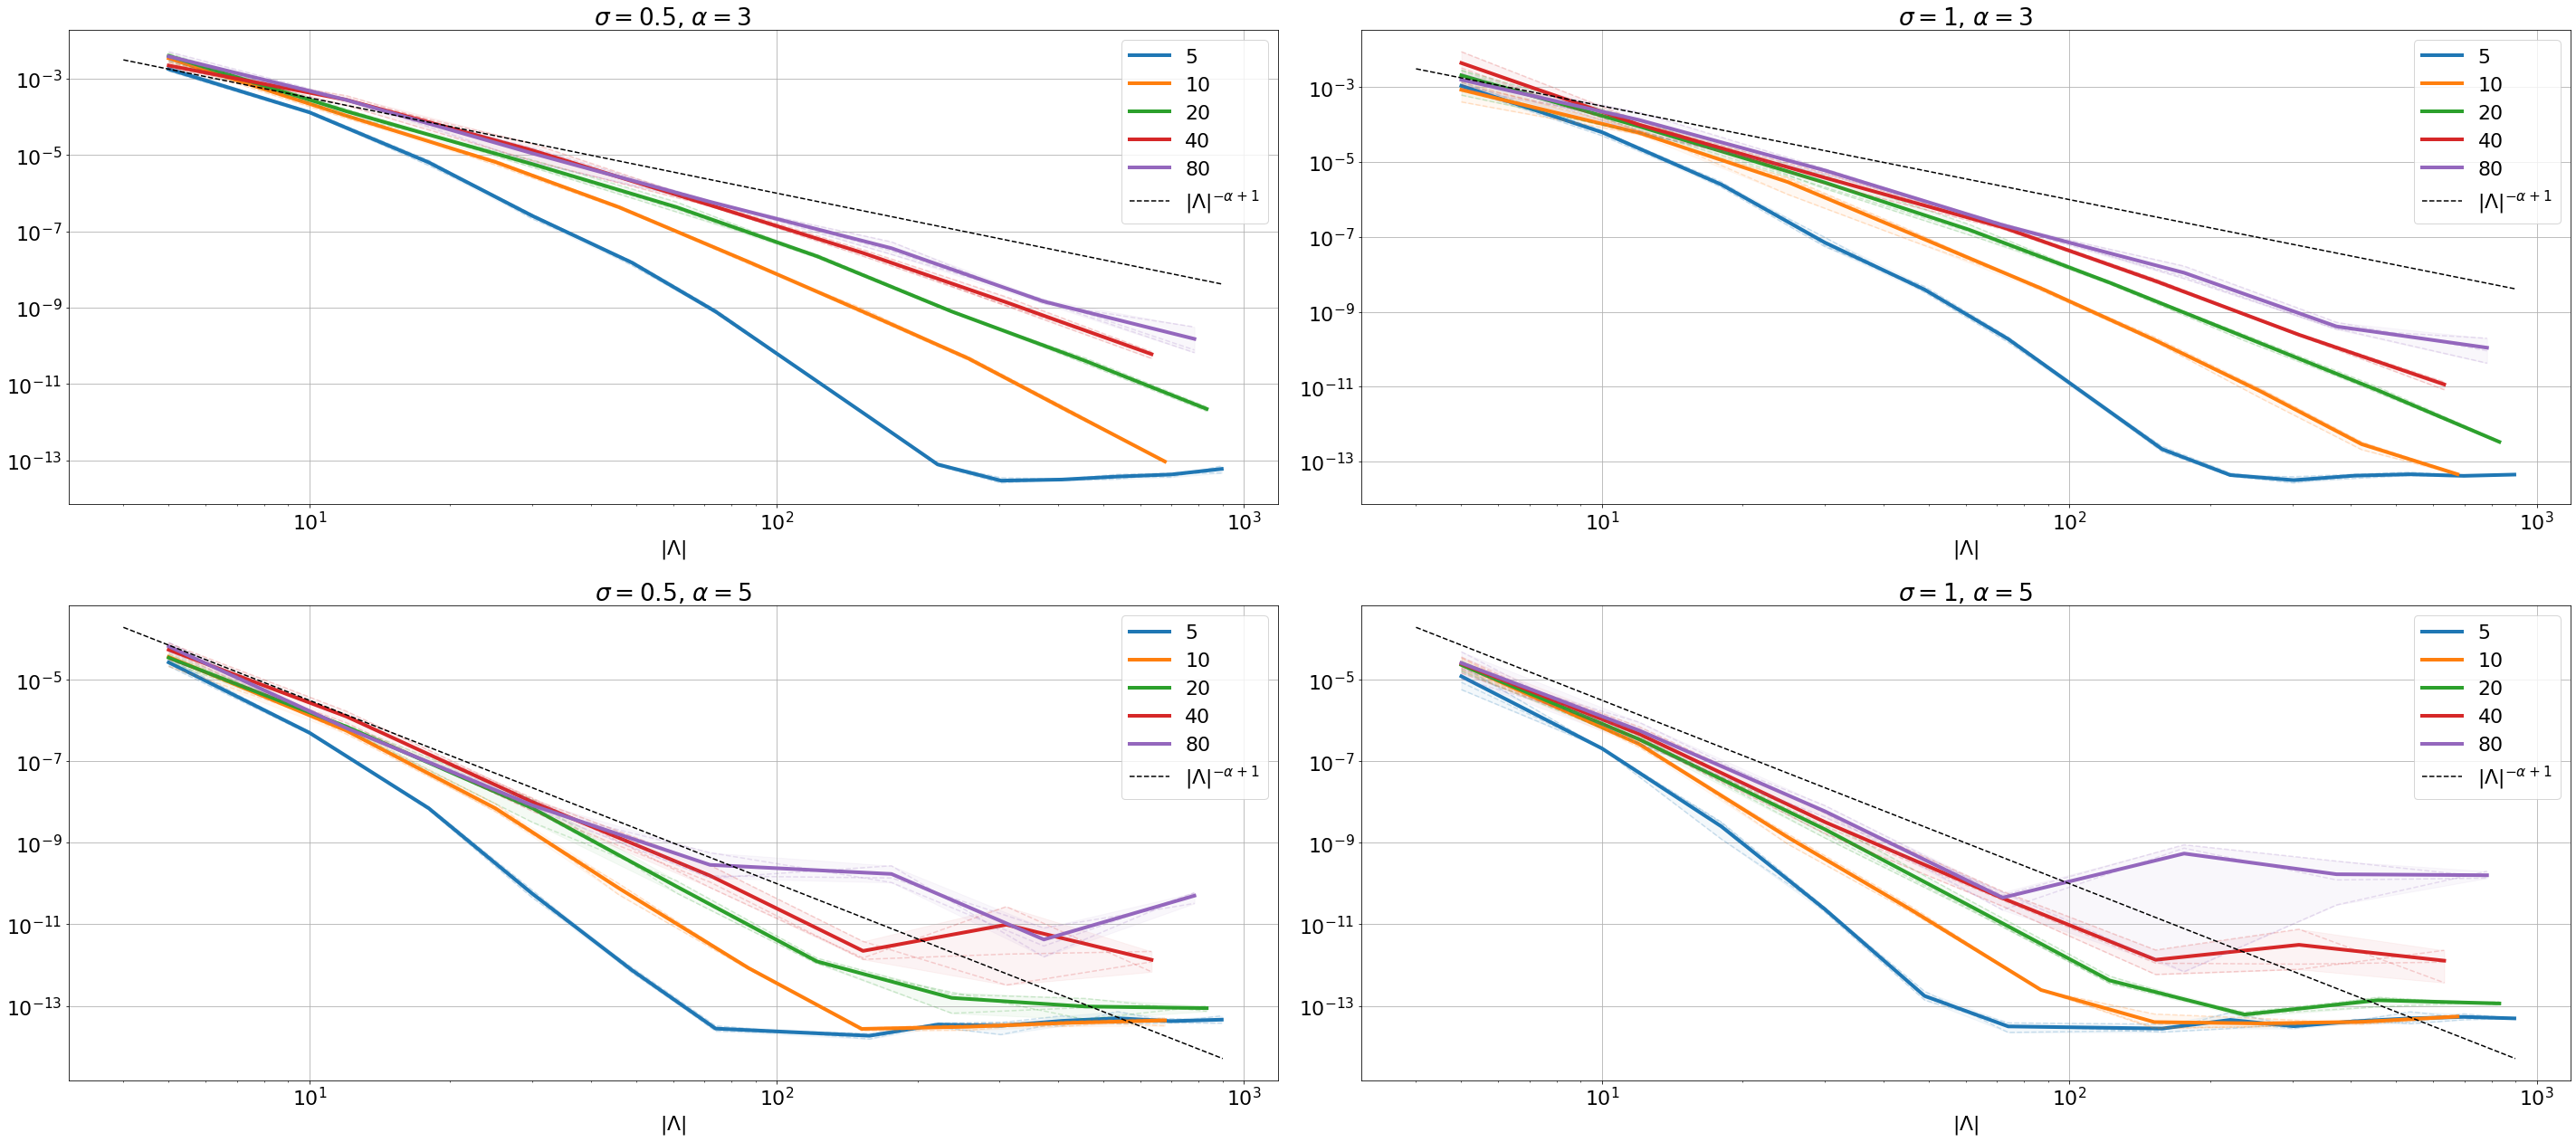

In [11]:
plot_convergence(method='wls', basis='hats_cdec', xeval=np.linspace(-1,1,7))

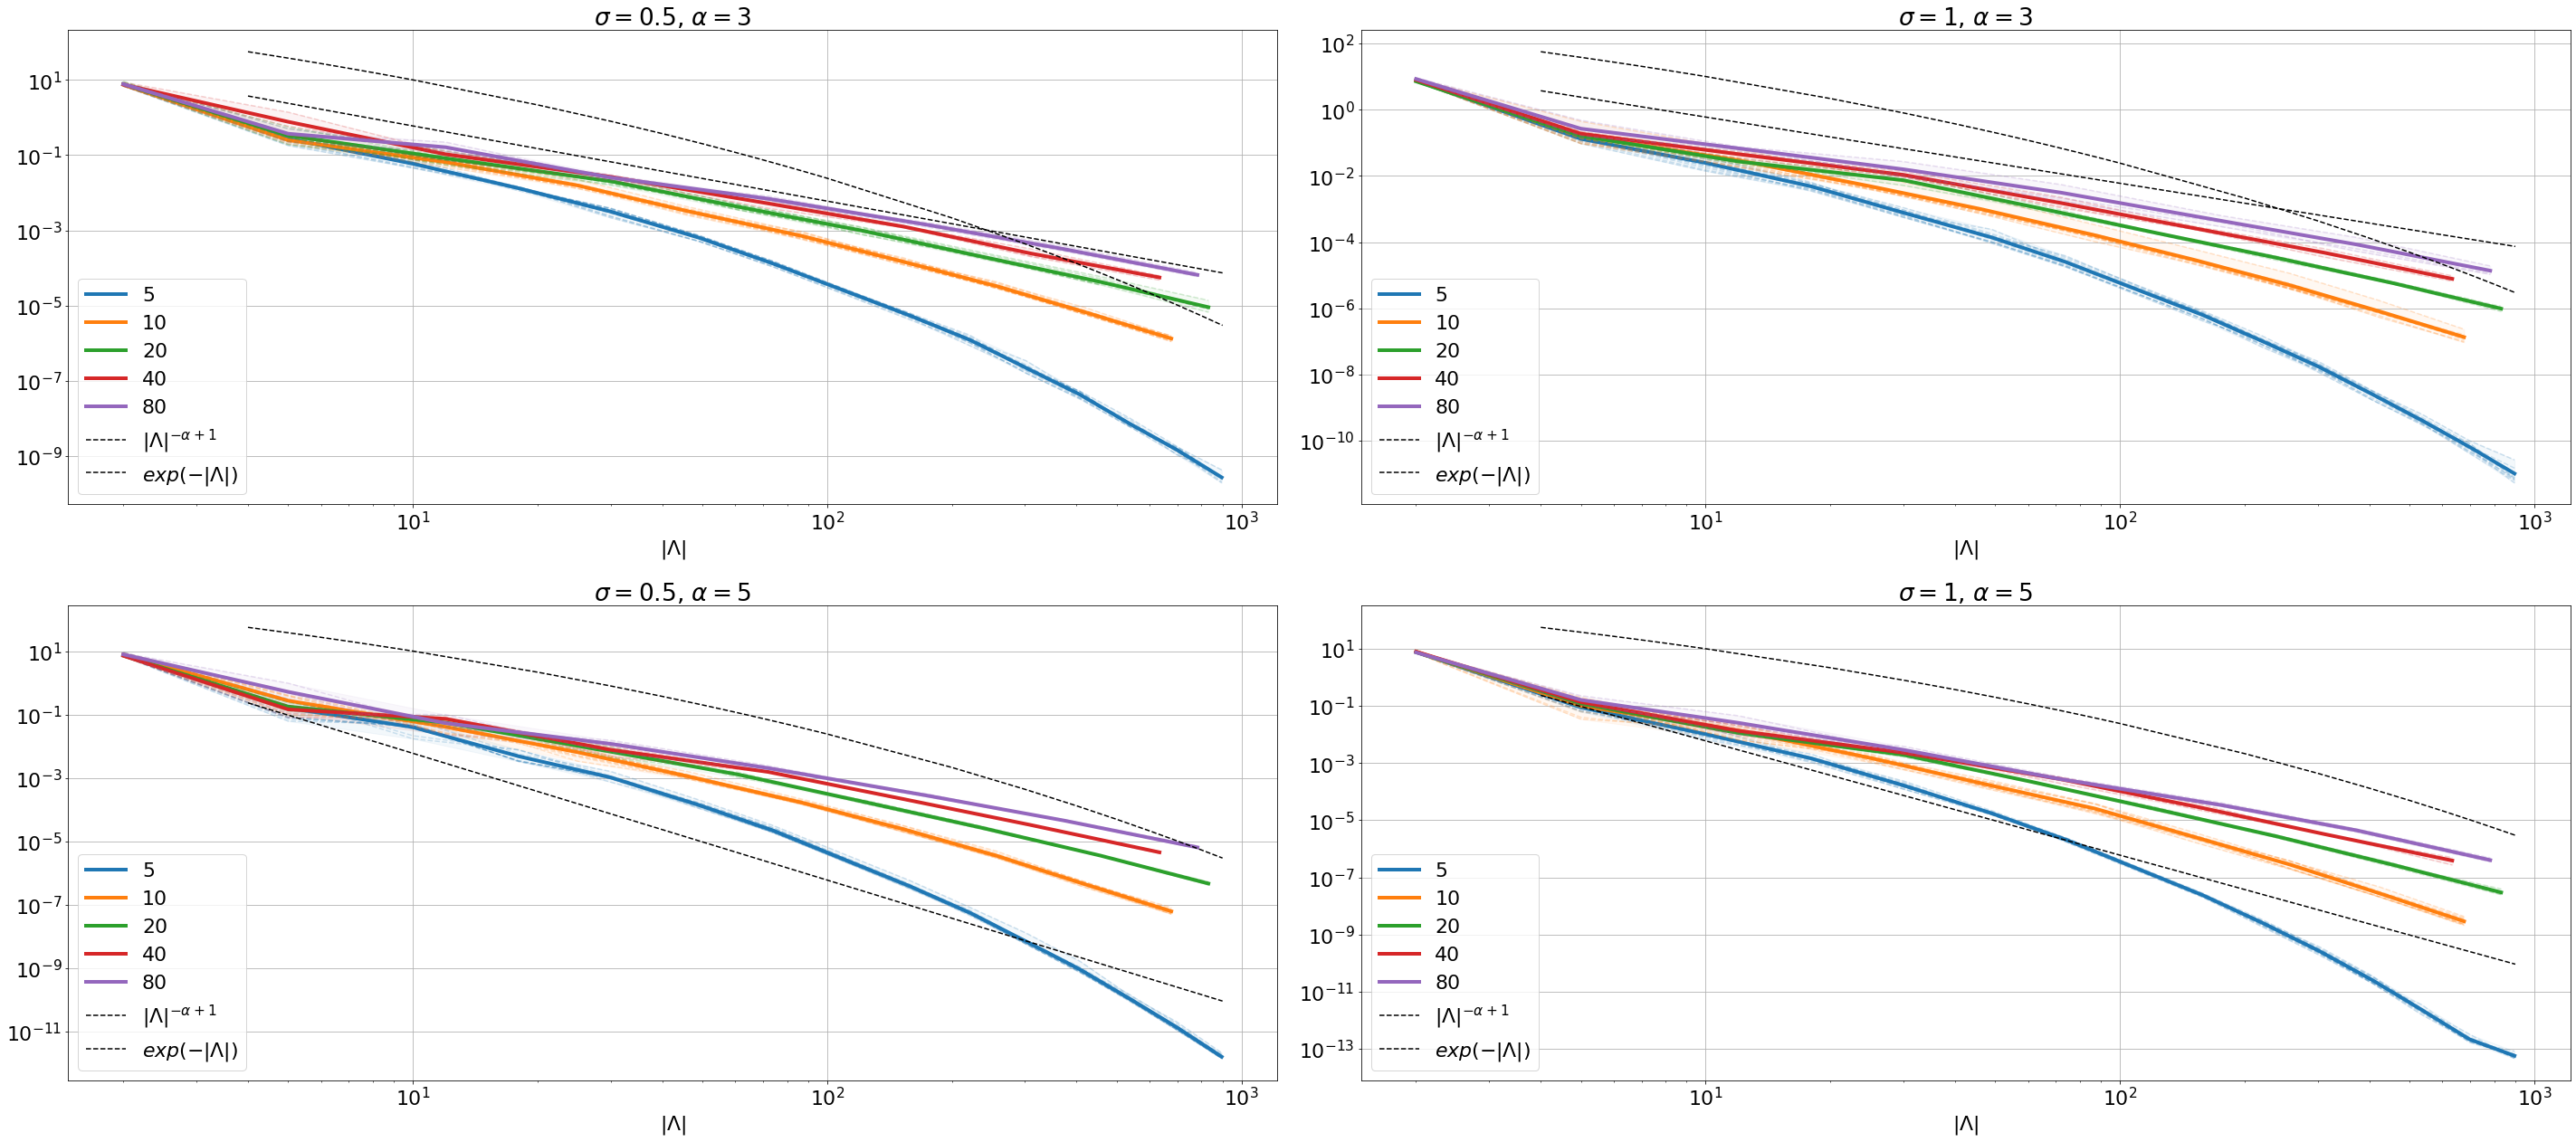

In [18]:
plot_convergence(method='wls', xeval=np.linspace(-1,1,7))

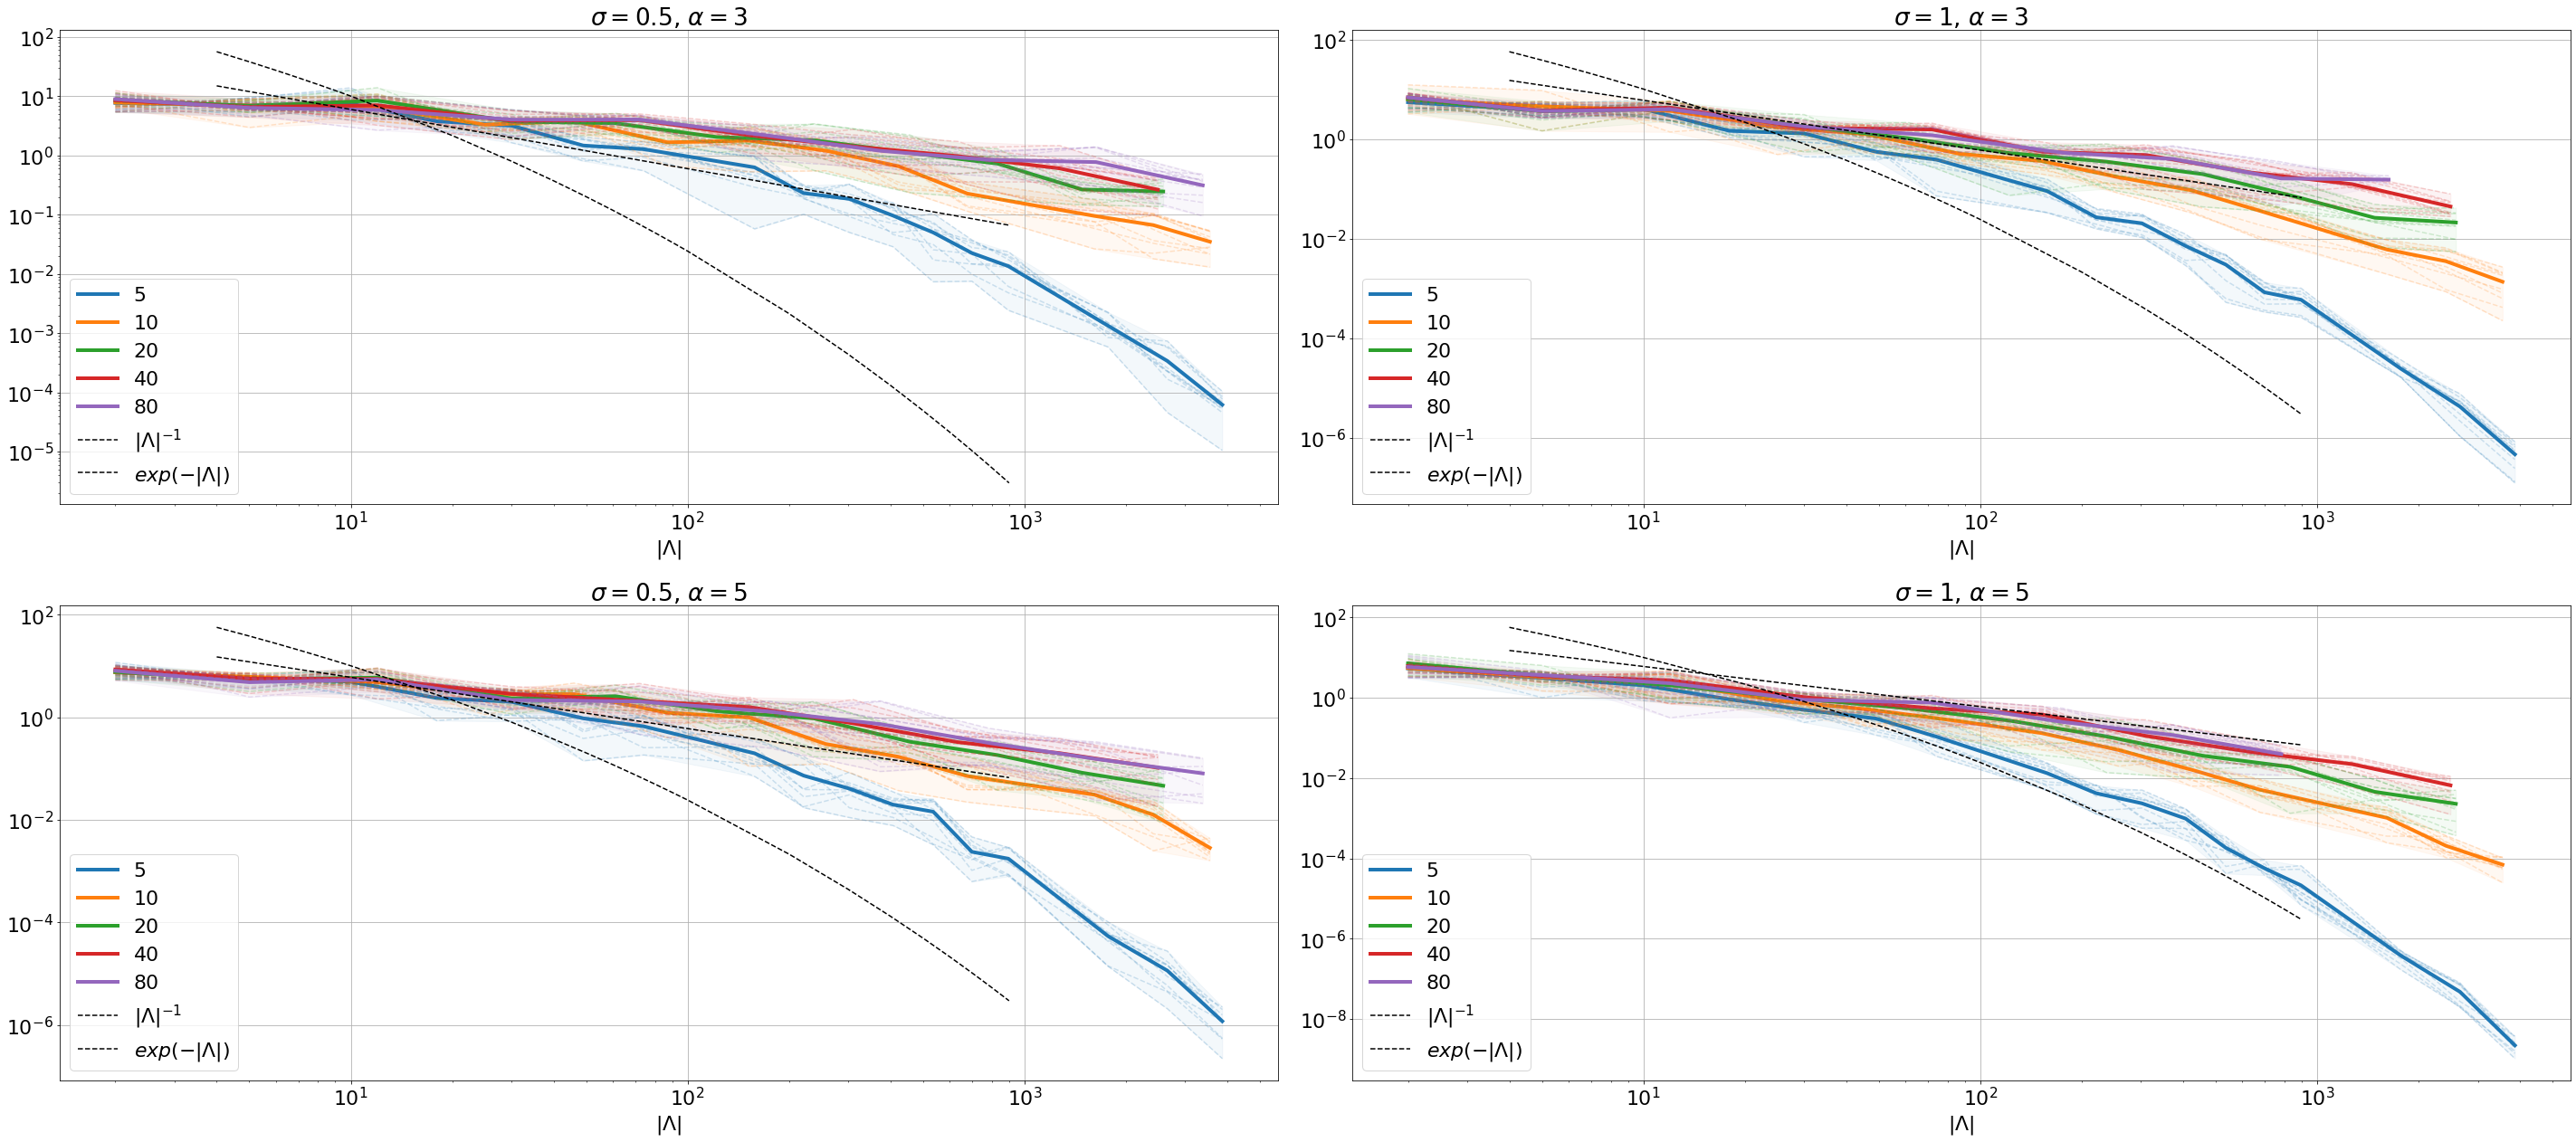

In [3]:
plot_convergence()

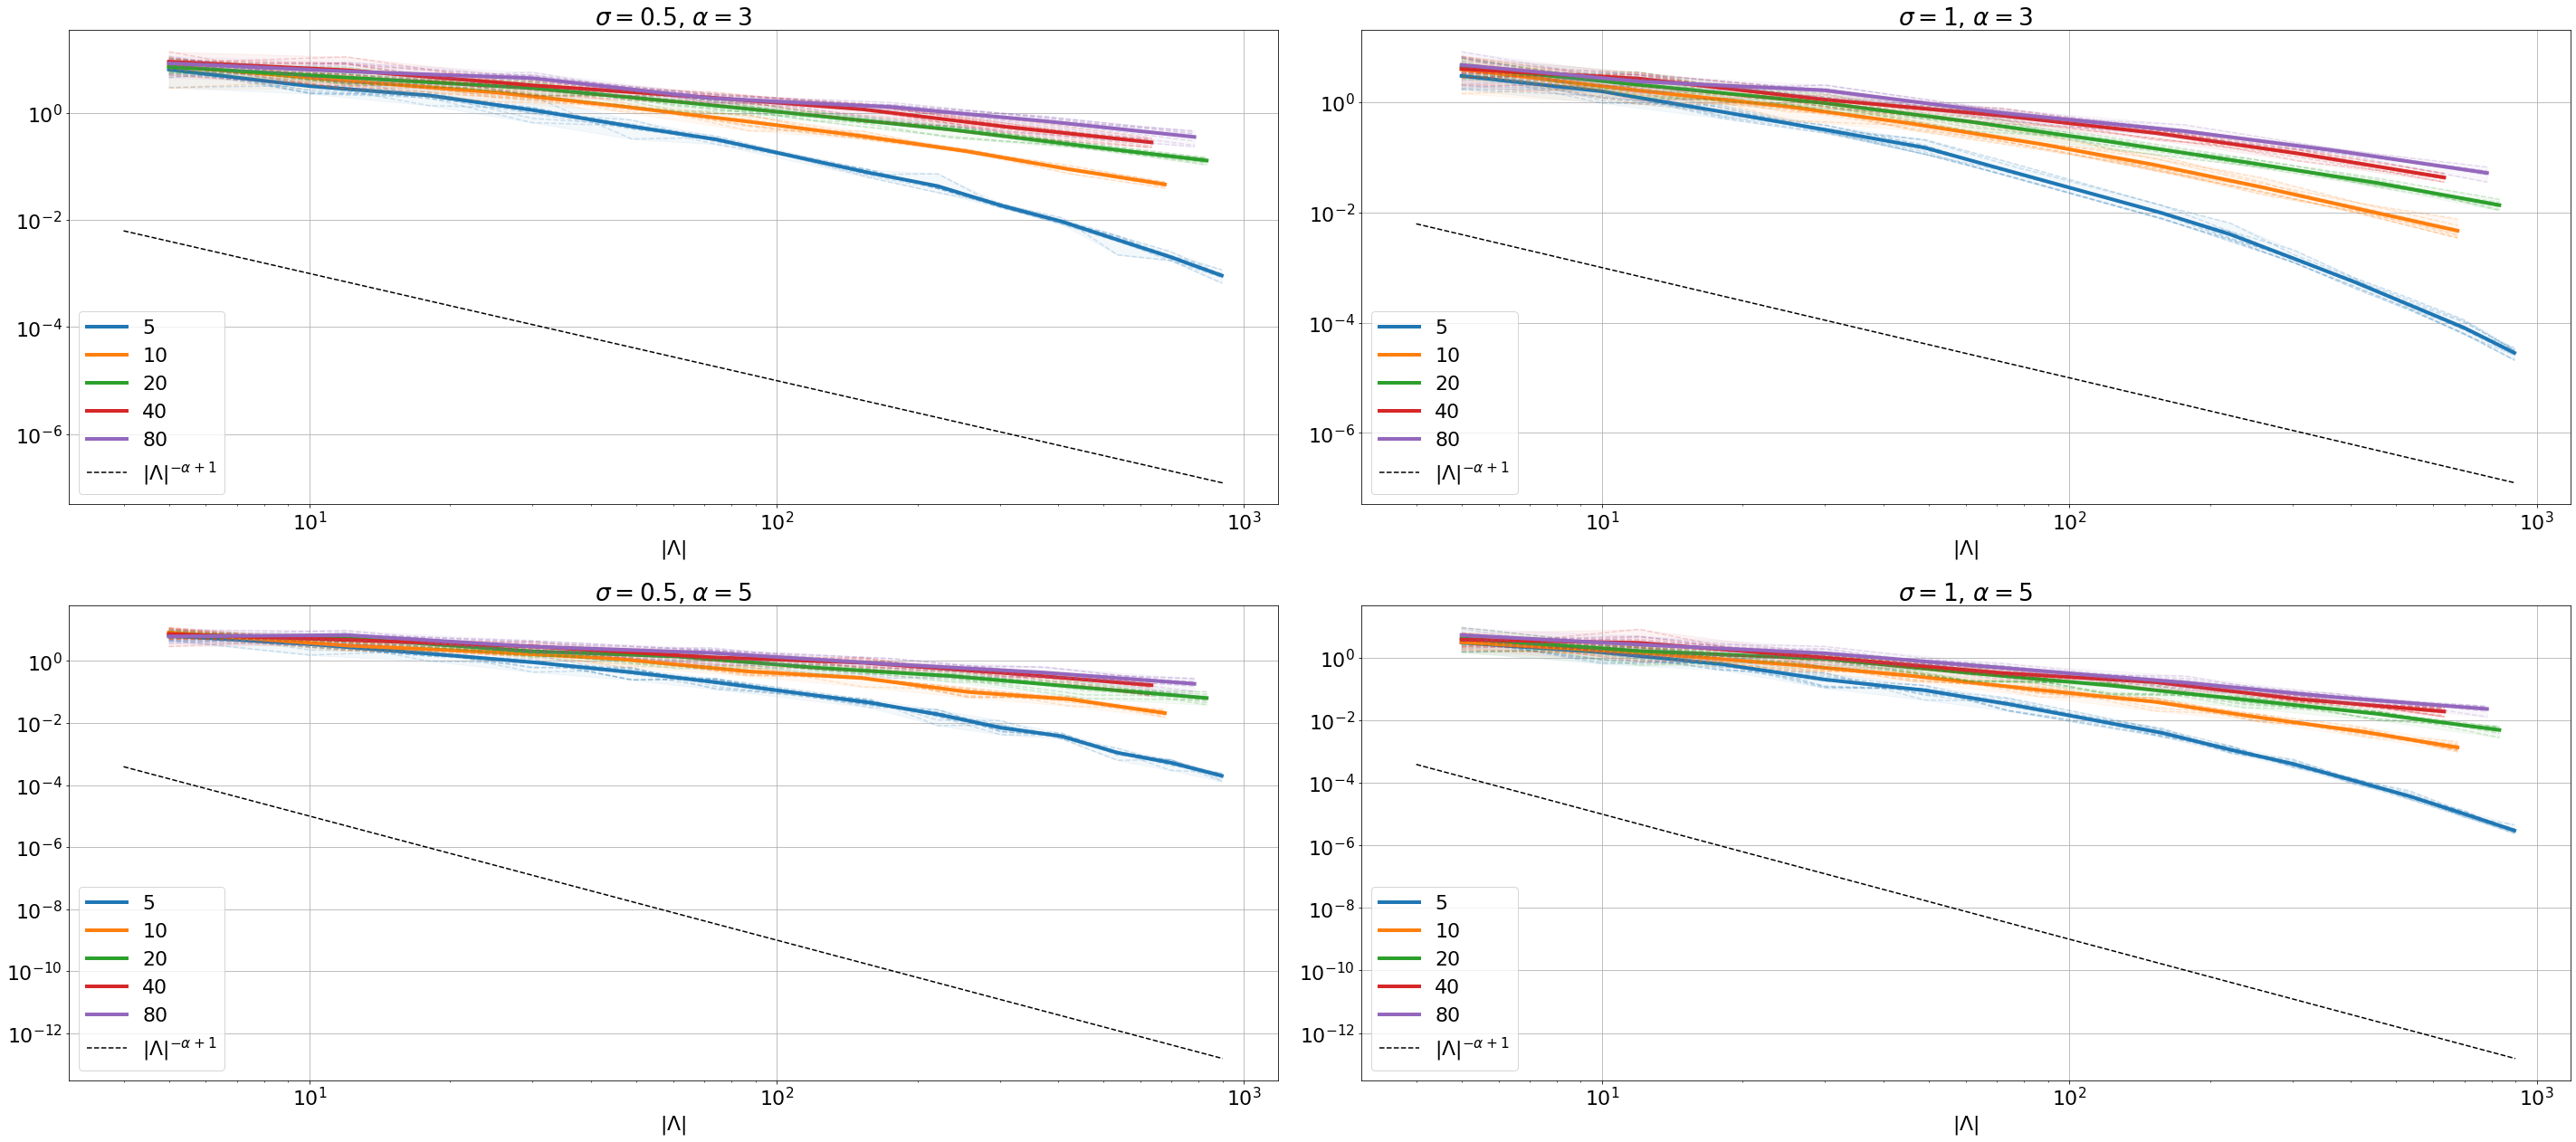

In [9]:
plot_convergence(method='wls', xeval=np.linspace(-1,1,101))

1 5 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
1 5 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
1 5 [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
1 5 [10, 10, 10, 10, 10, 10, 10, 10, 10]
1 5 [10, 10, 10, 10, 10, 10, 10, 10, 10]


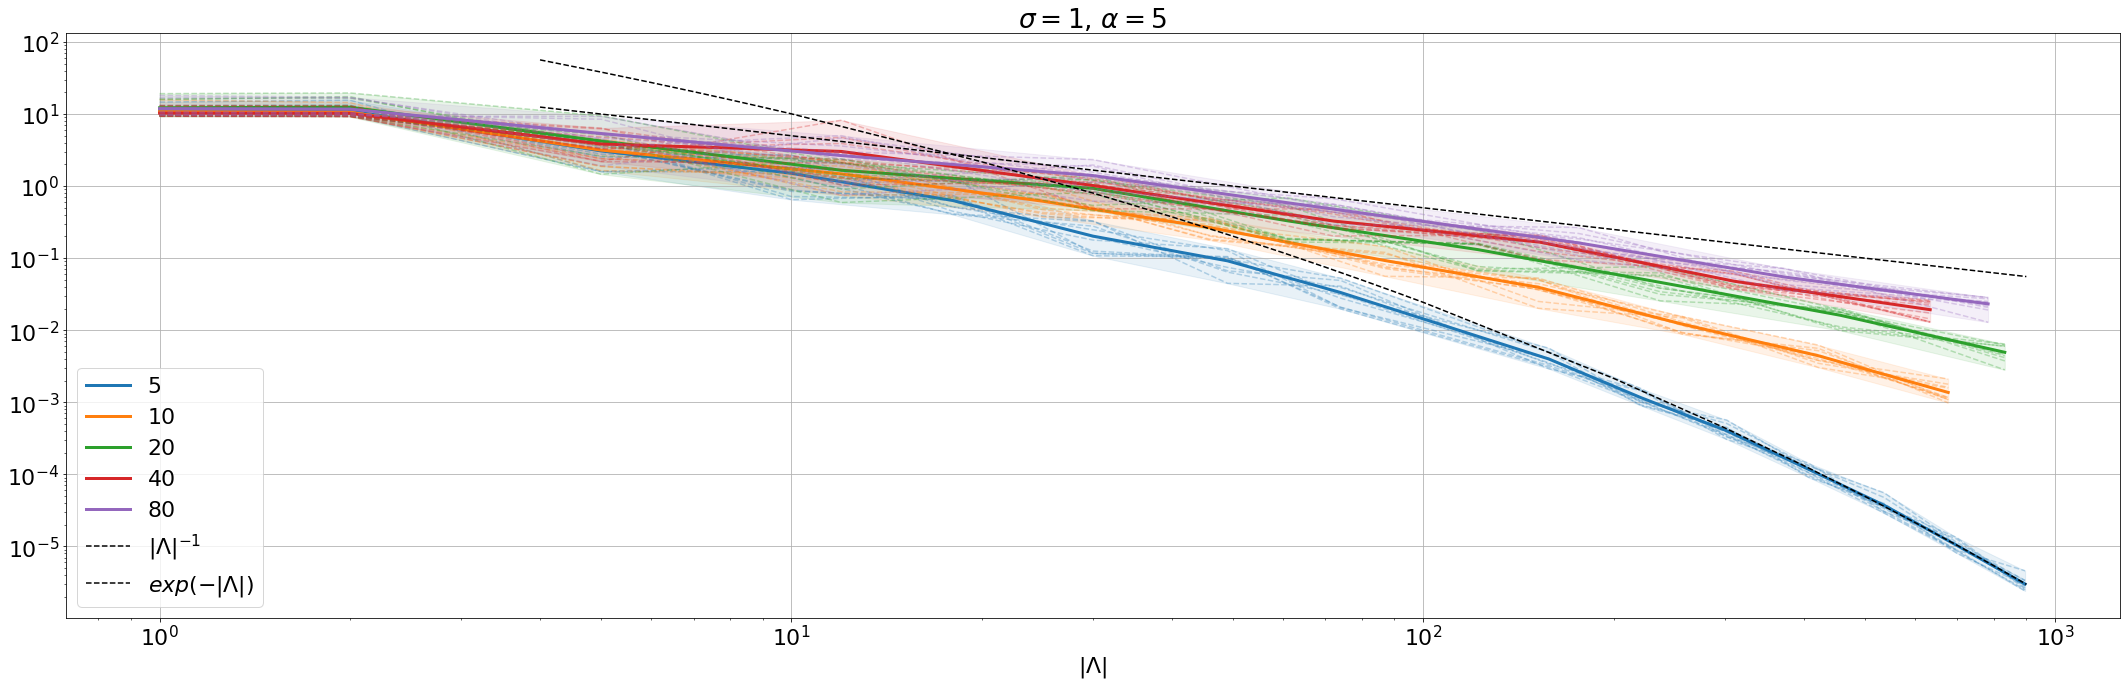

In [10]:
mins = {}
#mins = {1 : 2, 2 : 3, 3 : 4, 4 : 5, 5 : 6, 10 : 9}
dist = 'l2dist'

ds = [5,10,20,40,80]
alphas = [5]
noises = [1]

for d in ds :
    if d not in mins.keys() : mins[d] = 0

fig = plt.figure(figsize=(30., 10.))

x = np.array([i*base for base in [1, 10, 100] for i in range(1,10)], dtype=float)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j, alpha in enumerate(alphas) :
    for k, noise in enumerate(noises) :
        ax = plotutil.get_ax(fig, len(noises), j*len(noises) + k + 1, ny=len(alphas), 
                             xlabel=r'$|\Lambda|$', title=r'$\sigma=$'+str(noise)+r', $\alpha=$'+str(alpha), logaxis=['x', 'y'])
        for (i, d) in enumerate(ds) :
            q = query_gauss.format('tar.id, mul.size, evl.'+dist, 'multiindexsetanisotropicdbo', d, noise, alpha, 'wls')
            cursor = DB.execute_sql(q)
            col_names = [col[0] for col in cursor.description] 
            res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
            res2 = dict()
            for gk, g in itertools.groupby(res, lambda x : x['id']) :
                #print(gk)
                data = np.array([[r['size'], r[dist]] for r in sorted(g, key=lambda x :  x['size']) if r['size'] >= mins[d] and r[dist] is not None])
                try :
                    if len(data) > 0 :
                        plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.3)
                except IndexError :
                    print(d, data)

                for da in data :
                    if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
                    else : res2[da[0]].append(da[1])

            if res2 :
                keys = [k for k in sorted(res2.keys())]
                print(noise, alpha, [len(res2[k]) for k in keys])
                mean = [np.mean(res2[k]) for k in keys]
                minm = [np.min(res2[k]) for k in keys]
                maxm = [np.max(res2[k]) for k in keys]
                ax.plot(keys, mean, c=cycle[i], lw=3, label=str(d))
                ax.fill_between(keys, minm, maxm, color=cycle[i], alpha=.1)
        ax.plot(x[3:], 50*x[3:]**(-1), 'k--', label=r'$|\Lambda|^{-1}$')
        ax.plot(x[3:], 3e5*np.exp(-6.5*np.power(x[3:],1/5)), 'k--', label=r'$exp(-|\Lambda|)$')
        #ax.set_ylim(bottom=5e-4)
        ax.legend()
plt.tight_layout()
plt.show()

# Convolution of a series expansion

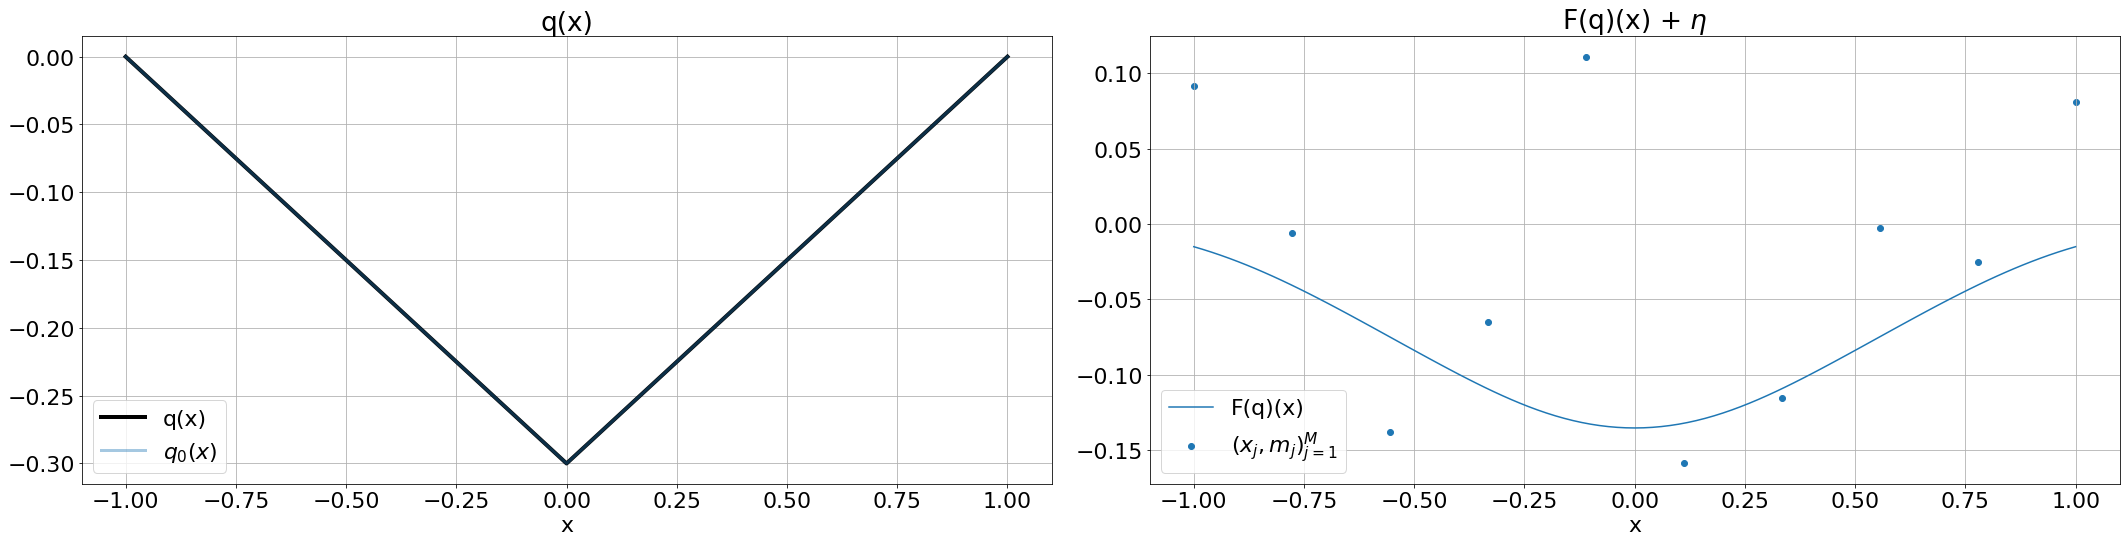

In [2]:
x_meas = np.linspace(-1,1,10)
x_eval = np.linspace(-1,1,101)
param  = np.array([-.3])
noise = .1
d = len(param)
q = basis.hats
alpha = 1
verbose = False

t = GaussianPosterior(forwd=fw.Convolution(basis=q, dim=d, alpha=alpha, noise=noise), truep=param, xeval=x_eval, noise=noise)
m = SparseSet.withSize(weights=t.forwd.weights, n=5, t=1, verbose=verbose)
s = Legendre(multis=m, target=t, method='wls', verbose=verbose)

F_x_meas = t.forwd.eval(param, xeval=x_meas) + noise*np.random.randn(len(x_meas),1)
F_x_eval = t.forwd.eval(param, xeval=x_eval)

fig = plt.figure(figsize=(30,8))
ax = plotutil.get_ax(fig, 2, 1, title='q(x)')
ax.plot(x_eval, [q(xi, param, alpha) for xi in x_eval], 'k', lw=4, label='q(x)')
for i in range(len(param)) :
    ax.plot(x_eval, [q(xi, [0]*i + [param[i]], alpha) for xi in x_eval], lw=3, label=r'$q_{}(x)$'.format(i), alpha=.4)
ax.legend()
ax = plotutil.get_ax(fig, 2, 2, title=r'F(q)(x) + $\eta$')
ax.plot(x_eval, F_x_eval, label='F(q)(x)')
ax.scatter(x_meas, F_x_meas, label=r'$(x_j, m_j)_{j=1}^M$')
ax.legend()
plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/target_and_convolution_{}d.'.format(alpha, d)
    plt.savefig(filename+'pdf', format='pdf')
    tikzplotlib.save(filename+'tex')

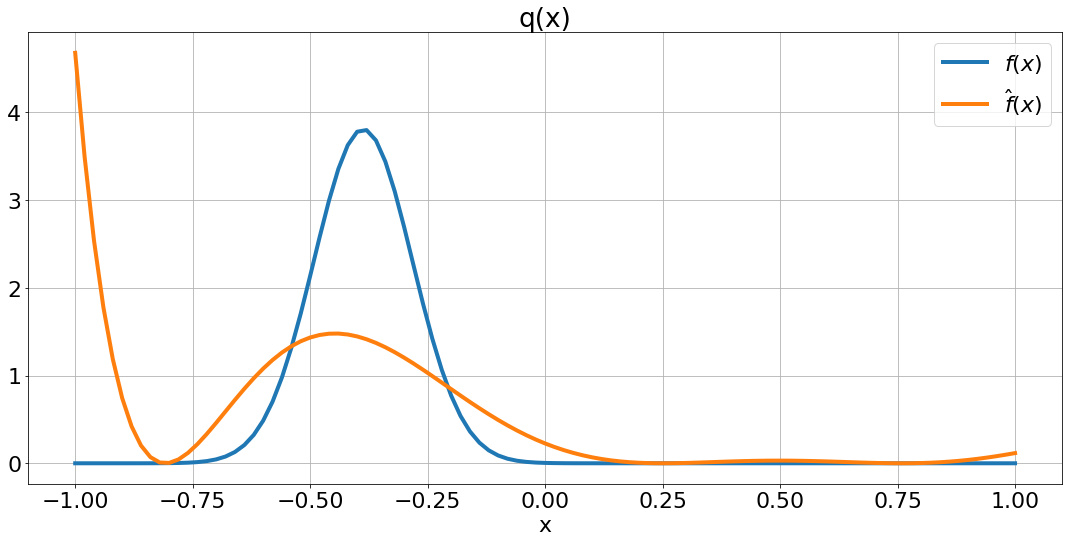

In [3]:
teval = [t.eval(np.array([xi]))/(2/len(x_eval)) for xi in x_eval]
seval = [s.eval(np.array([xi]))/(2/len(x_eval)) for xi in x_eval]
dx = 2/(len(x_eval)-1)
teval_norm = .5*dx*(teval[0] + teval[-1]) + np.sum(teval[1:-1])*dx
seval_norm = .5*dx*(seval[0] + seval[-1]) + np.sum(seval[1:-1])*dx
fig = plt.figure(figsize=(30,8))
ax = plotutil.get_ax(fig, 2, 1, title='q(x)')
ax.plot(x_eval, teval/teval_norm, lw=4, label=r'$f(x)$')
ax.plot(x_eval, seval/seval_norm, lw=4, label=r'$\hat{f}(x)$')
ax.legend()
plt.tight_layout()

select tar.id, mul.size, evl.l2dist
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussianposteriordbo as tar 
    on sur.target_id = tar.id
   and sur.target = 'posterior'
  join multiindexsetanisotropicdbo as mul
    on sur.multis_id = mul.id
  join forwarddbo as fwd
    on tar.forwd_id = fwd.id
 where fwd.dim = 1
   and fwd.noise = .1
   and fwd.alpha = 1

3 0.5 [1, 1, 4, 13, 13, 13, 13, 13, 13, 12, 12, 9, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
3 0.5 [1, 2, 26, 26, 25, 12, 12, 12, 12, 9, 9, 9, 9, 9, 9, 6, 6, 4, 4, 4, 4, 4]
3 0.5 [2, 4, 24, 24, 10, 10, 20, 10, 20, 10, 10, 7, 7, 7, 7, 7, 7, 7]
3 0.5 [2, 4, 16, 6, 6, 12, 6, 6, 6, 6, 6, 6, 6, 6, 6]
3 0.5 [2, 4, 18, 7, 7, 7, 7, 7, 7, 7, 7]
3 0.5 [14, 7, 14, 7, 7, 7, 7]
3 0.5 [14, 7, 14, 7, 7, 7]
3 1 [1, 1, 2, 11, 11, 11, 11, 11, 11, 10, 9, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
3 1 [1, 2, 22, 22, 21, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 6, 4, 4, 4, 4, 4, 4]
3 1 [1, 2, 18, 18, 8, 8, 16, 8, 16, 8, 7, 7, 7, 7, 7, 4, 4, 4]
3 1 [2, 4, 18, 7, 7, 14, 7, 7, 7, 7, 6, 6, 6, 6, 6]
3 1 [2, 4, 18, 7, 7, 7, 7, 7, 7, 7, 7]
3 1 [14, 7, 14, 7, 7, 7, 7]
3 1 [12, 6, 12, 6, 6, 6]
5 0.5 [1, 1, 5, 14, 14, 14, 14, 14, 14, 13, 13, 9, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
5 0.5 [1, 2, 28, 28, 27, 13, 13, 13, 13, 9, 9, 9, 9, 9, 9, 6, 4, 4, 4, 4, 4, 4]
5 0.5 [2, 4, 25, 24, 11, 11, 22, 11, 22, 11, 11, 7, 7, 7

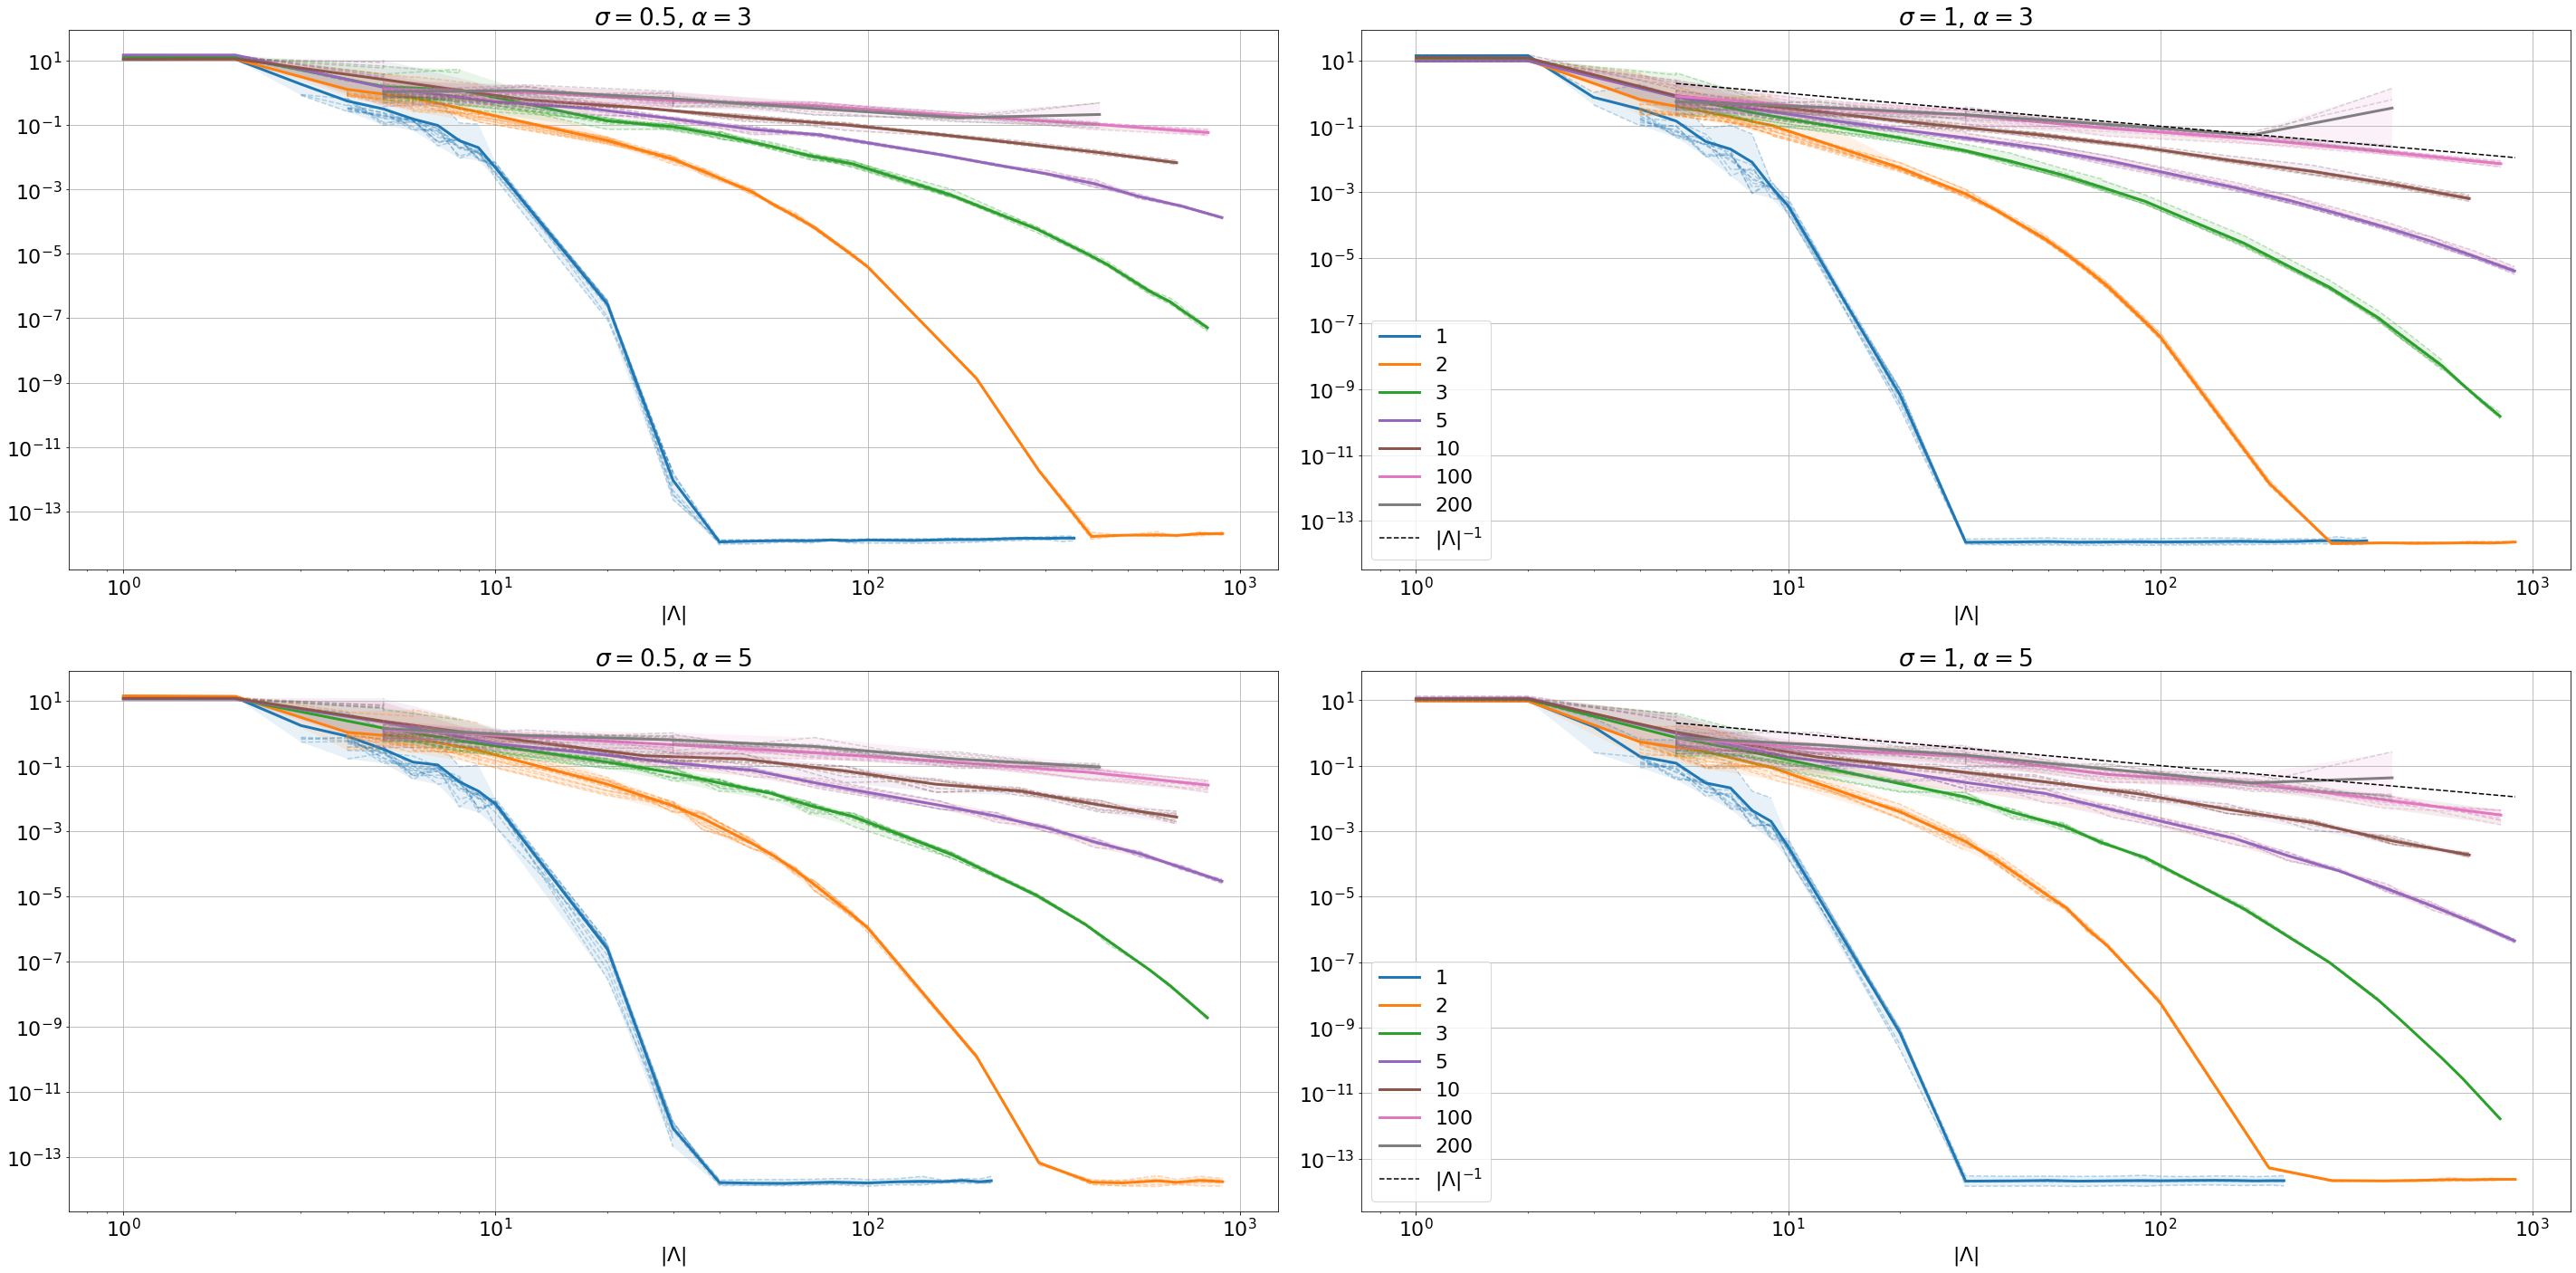

In [13]:
mins = {}
#mins = {1 : 2, 2 : 3, 3 : 4, 4 : 5, 5 : 6, 10 : 9}
dist = 'l2dist'

ds = [5,10,20,40,80,160]
alphas = [3,5]
noises = [.5,1]

for d in ds :
    if d not in mins.keys() : mins[d] = 0

fig = plt.figure(figsize=(40., 20.))

x = np.array([i*base for base in [1, 10, 100] for i in range(1,10)], dtype=float)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j, alpha in enumerate(alphas) :
    for k, noise in enumerate(noises) :
        ax = plotutil.get_ax(fig, len(noises), j*len(noises) + k + 1, ny=len(alphas), 
                             xlabel=r'$|\Lambda|$', title=r'$\sigma=$'+str(noise)+r', $\alpha=$'+str(alpha), logaxis=['x', 'y'])
        for (i, d) in enumerate(ds) :
            q = query_gauss.format('tar.id, mul.size, evl.'+dist, 'multiindexsetanisotropicdbo', d, noise, alpha)
            cursor = DB.execute_sql(q)
            col_names = [col[0] for col in cursor.description] 
            res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
            res2 = dict()
            for k, g in itertools.groupby(res, lambda x : x['id']) :
                data = np.array([[r['size'], r[dist]] for r in sorted(g, key=lambda x :  x['size']) if r['size'] >= mins[d] and r[dist] is not None])
                try :
                    if len(data) > 0 :
                        plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.3)
                except IndexError :
                    print(d, data)

                for da in data :
                    if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
                    else : res2[da[0]].append(da[1])

            if res2 :
                keys = [k for k in sorted(res2.keys())]
                print(noise, alpha, [len(res2[k]) for k in keys])
                mean = [np.mean(res2[k]) for k in keys]
                minm = [np.min(res2[k]) for k in keys]
                maxm = [np.max(res2[k]) for k in keys]
                ax.plot(keys, mean, c=cycle[i], lw=3, label=str(d))
                ax.fill_between(keys, minm, maxm, alpha=.1)
    ax.plot(x[4:], 10*x[4:]**(-1), 'k--', label=r'$|\Lambda|^{-1}$')
    #ax.set_ylim(bottom=5e-4)
    ax.legend()
plt.tight_layout()
plt.show()

# Convergence

data_conv_hats_alpha=1
data_conv_hats_alpha=2
data_conv_hats_alpha=4
data_conv_hats_alpha=8


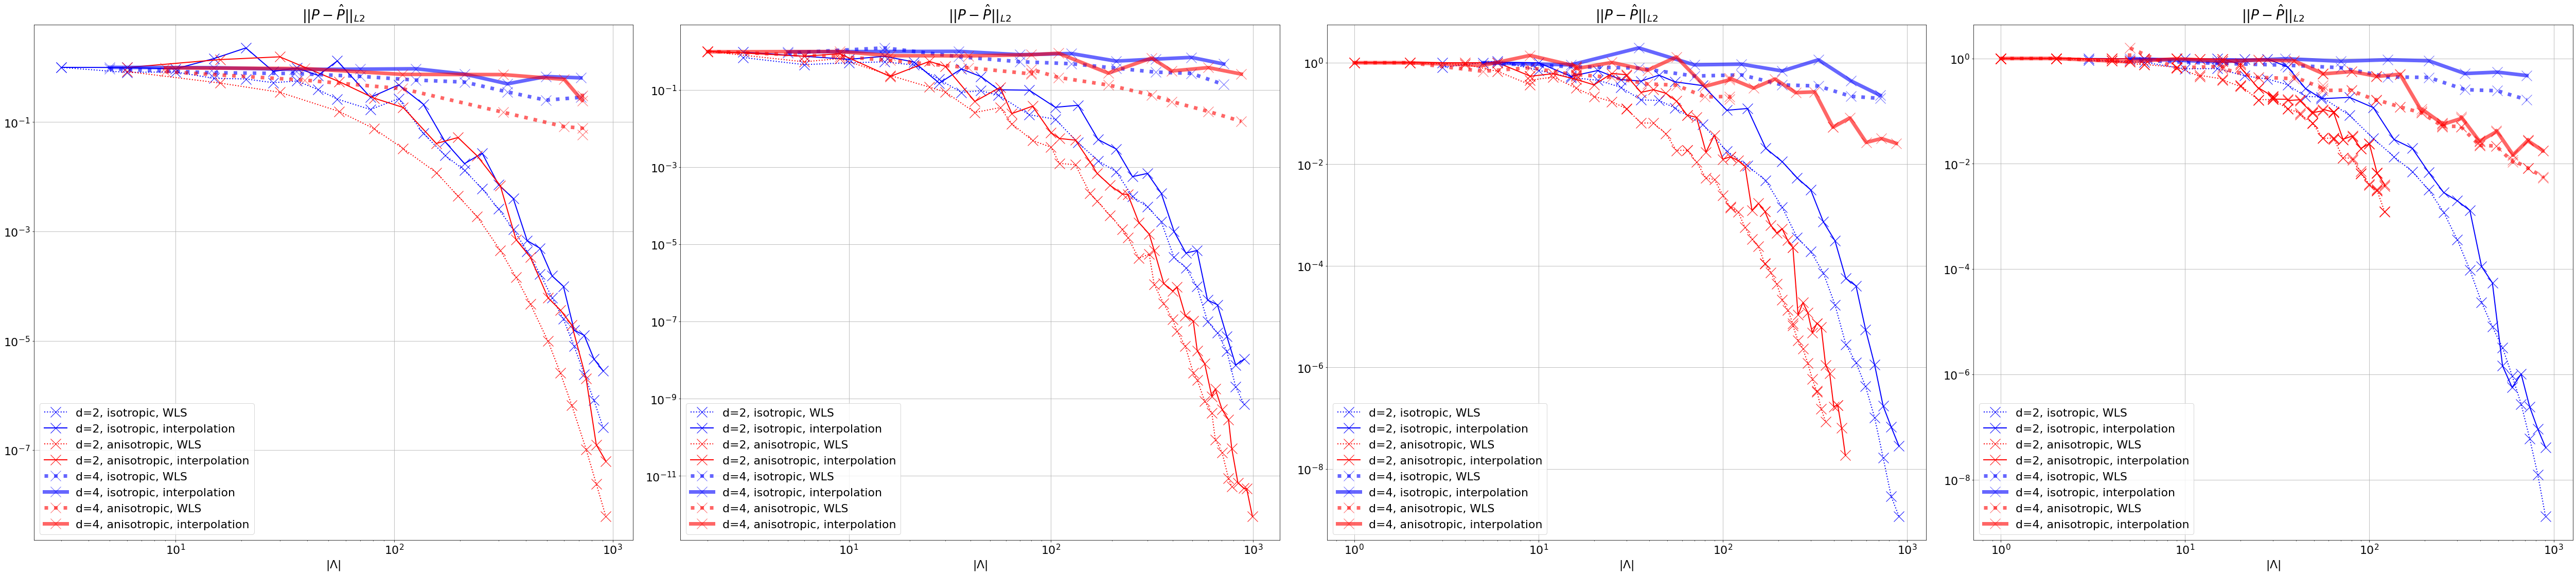

In [4]:
fig =  plt.figure(figsize=(70,16))
ls = {'ip' : '-', 'ls' : '-.', 'wls' : ':'}
cc = {'order' : 'b', 'eps' : 'r'}
al = {'d=2' : 1, 'd=4' : .6, 'd=8' : .3, 'd=16' : .1, }
lw = {'d=2' : 2, 'd=4' : 7, 'd=8' : 13, 'd=16' : 18}
set_type_mapped = {'order' : 'isotropic', 'eps' : 'anisotropic'}
appr_mapped = {'ip' : 'interpolation', 'wls' : 'WLS', 'ls': 'LS'}

basis_type = 'hats'
alphas = [1,2,4,8]
for i in range(len(alphas)) :
    
    ax = plotutil.get_ax(fig, 4, i+1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    data_dir = 'data_conv_{}_alpha={}'.format(basis_type, alphas[i])
    print(data_dir)
    for dim_dir in ['d=2', 'd=4'] : #sorted(os.listdir(data_dir)) :
        for param_dir in os.listdir(data_dir+'/'+dim_dir) :
            for sigma_dir in ['s=0.1'] : #[x for x in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir) if re.match('s=*', x)] :
                for m_dir in ['m=1']: #os.listdir(data_dir+'/'+dim_dir+'/'+param_dir+'/'+sigma_dir) :
                    for set_type in ['order', 'eps'] :
                        for appr in ['ls', 'wls', 'ip'] :
                            for intg in ['mc'] :
                                lambdas, l2 = load_results(d=int(dim_dir.split('=')[1]), p=int(param_dir.split('=')[1]), sigma=float(sigma_dir.split('=')[1]), m=int(m_dir.split('=')[1]), basis_type=basis_type, alpha=alphas[i], set_type=set_type, appr=appr, intg=intg)
                                if lambdas is not None :
                                    if m_dir == 'm=1' :
                                        ax.plot(lambdas, l2, marker='x', ms=20, ls=ls[appr], alpha=al[dim_dir], color=cc[set_type], linewidth=lw[dim_dir],
                                                 label='{}, {}, {}'.format(dim_dir, set_type_mapped[set_type], appr_mapped[appr]))

    ax.legend()

plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/l2_convergence.'.format(alpha)
    plt.savefig(filename+'pdf', format='pdf')

data_conv_steps_alpha=1
data_conv_steps_alpha=2
data_conv_steps_alpha=4
data_conv_steps_alpha=8


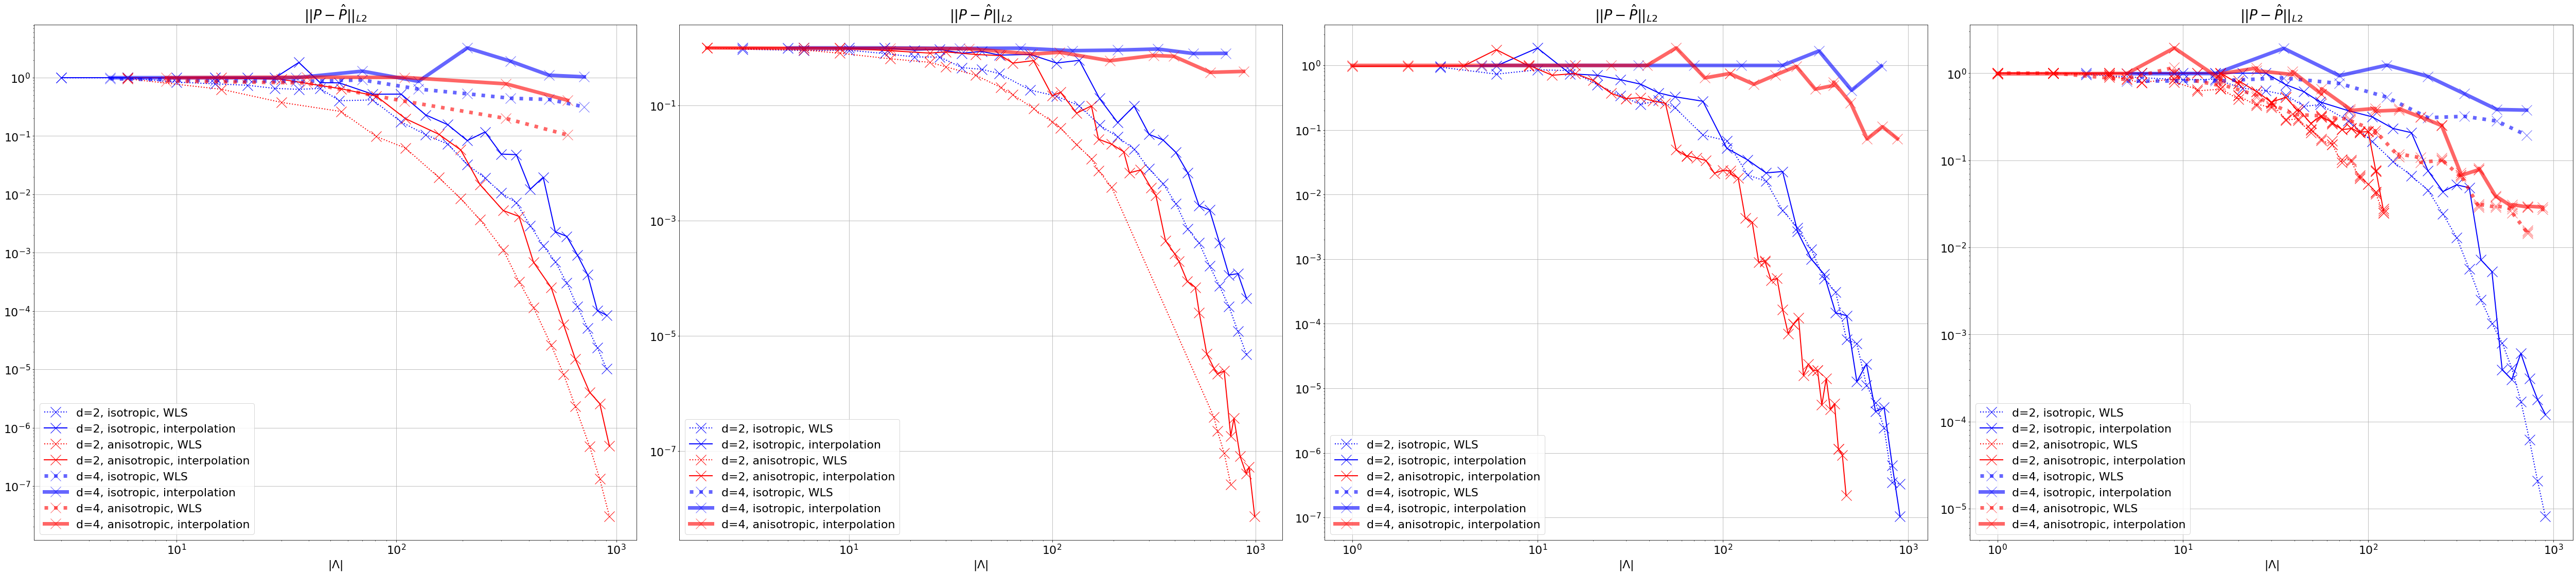

In [5]:
fig =  plt.figure(figsize=(70,16))
basis_type = 'steps'
alphas = [1,2,4, 8]
for i in range(len(alphas)) :
    
    ax = plotutil.get_ax(fig, 4, i+1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    data_dir = 'data_conv_{}_alpha={}'.format(basis_type, alphas[i])
    print(data_dir)
    for dim_dir in ['d=2', 'd=4'] : #sorted(os.listdir(data_dir)) :
        for param_dir in os.listdir(data_dir+'/'+dim_dir) :
            for sigma_dir in ['s=0.1'] : #[x for x in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir) if re.match('s=*', x)] :
                for m_dir in ['m=1']: #os.listdir(data_dir+'/'+dim_dir+'/'+param_dir+'/'+sigma_dir) :
                    for set_type in ['order', 'eps'] :
                        for appr in ['ls', 'wls', 'ip'] :
                            for intg in ['mc'] :
                                lambdas, l2 = load_results(d=int(dim_dir.split('=')[1]), p=int(param_dir.split('=')[1]), sigma=float(sigma_dir.split('=')[1]), m=int(m_dir.split('=')[1]), basis_type=basis_type, alpha=alphas[i], set_type=set_type, appr=appr, intg=intg)
                                if lambdas is not None :
                                    if m_dir == 'm=1' :
                                        ax.plot(lambdas, l2, marker='x', ms=20, ls=ls[appr], alpha=al[dim_dir], color=cc[set_type], linewidth=lw[dim_dir],
                                                 label='{}, {}, {}'.format(dim_dir, set_type_mapped[set_type], appr_mapped[appr]))

    ax.legend()

plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/l2_convergence.'.format(alpha)
    plt.savefig(filename+'pdf', format='pdf')

data_conv_hats_cdec_alpha=1
data_conv_hats_cdec_alpha=2
data_conv_hats_cdec_alpha=4
data_conv_hats_cdec_alpha=8


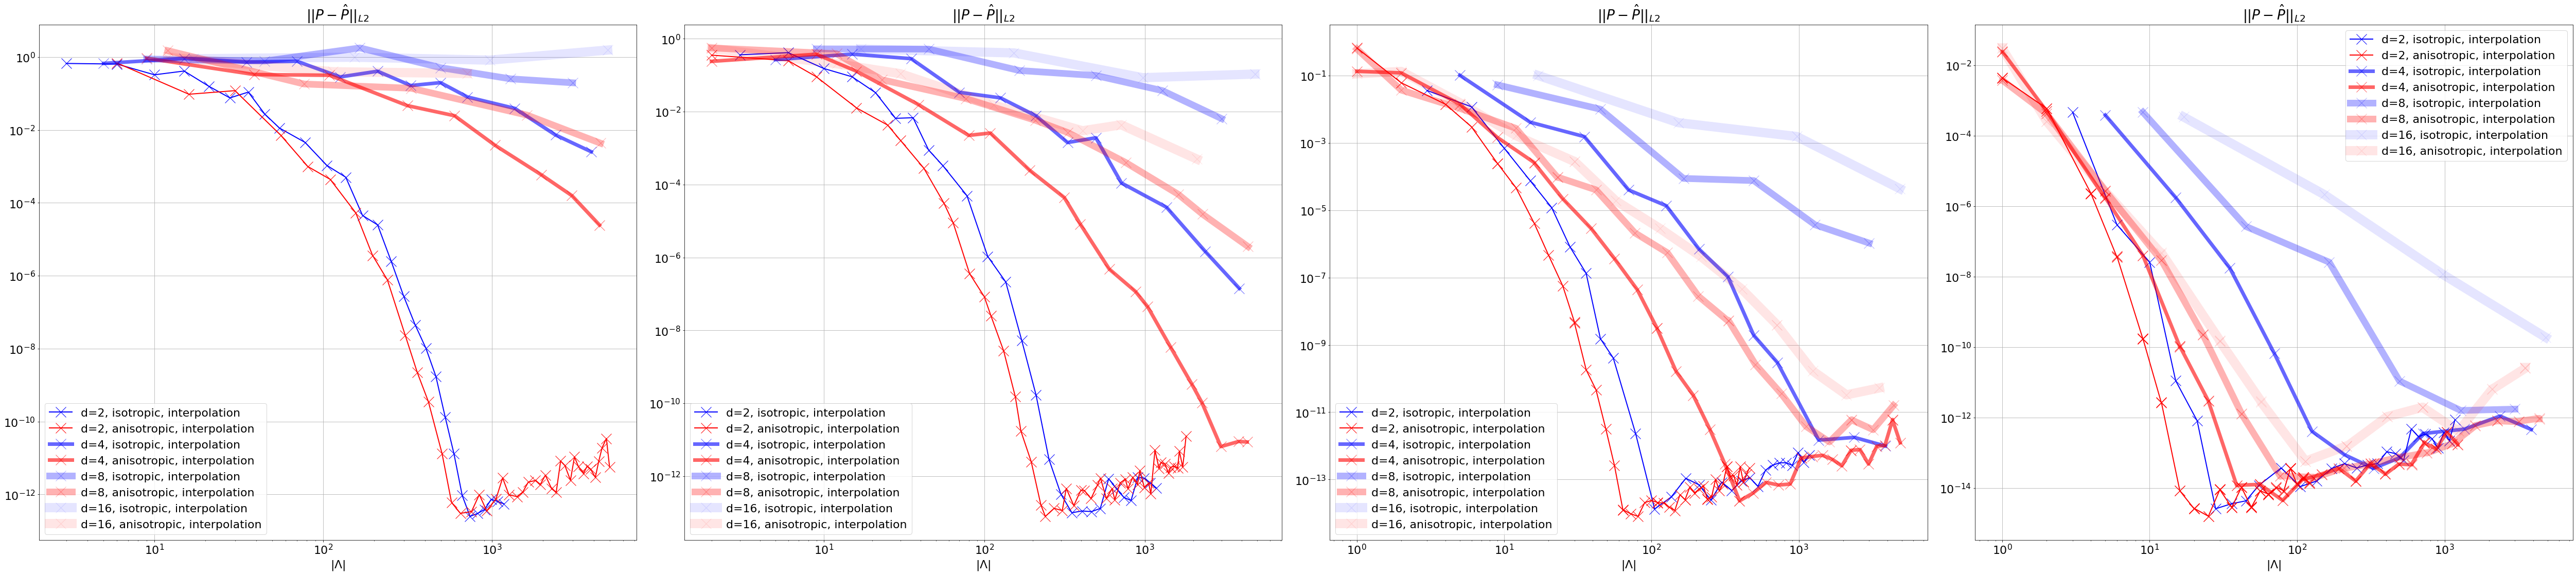

In [6]:
fig =  plt.figure(figsize=(70,16))
basis_type = 'hats_cdec'
alphas = [1,2,4, 8]
for i in range(len(alphas)) :
    
    ax = plotutil.get_ax(fig, 4, i+1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    data_dir = 'data_conv_{}_alpha={}'.format(basis_type, alphas[i])
    print(data_dir)
    for dim_dir in ['d=2', 'd=4', 'd=8', 'd=16'] : #sorted(os.listdir(data_dir)) : #
        for param_dir in os.listdir(data_dir+'/'+dim_dir) :
            for sigma_dir in [x for x in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir) if re.match('s=*', x)] :
                for m_dir in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir+'/'+sigma_dir) :
                    for set_type in ['order', 'eps'] :
                        for appr in ['ls', 'wls', 'ip'] :
                            for intg in ['mc'] :
                                lambdas, l2 = load_results(d=int(dim_dir.split('=')[1]), p=int(param_dir.split('=')[1]), sigma=float(sigma_dir.split('=')[1]), m=int(m_dir.split('=')[1]), basis_type=basis_type, alpha=alphas[i], set_type=set_type, appr=appr, intg=intg)
                                if lambdas is not None :
                                    if m_dir == 'm=1' :
                                        ax.plot(lambdas, l2, marker='x', ms=20, ls=ls[appr], alpha=al[dim_dir], color=cc[set_type], linewidth=lw[dim_dir],
                                                 label='{}, {}, {}'.format(dim_dir, set_type_mapped[set_type], appr_mapped[appr]))

    ax.legend()

plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/l2_convergence.'.format(alpha)
    plt.savefig(filename+'pdf', format='pdf')

In [64]:
target = lambda p : P(x_meas, m_x_meas, p, sigma)
p_grid = get_d_dim_grid_points(d)

l2_total_leja = [l2_distance(target, multisets_total[i], coeffs_total_leja[i], p_grid) for i in range(len(multisets_total))]
#l2_total_lstsq = [l2_distance(target, multisets_total[i], coeffs_total_lstsq[i], p_grid) for i in range(len(multisets_total))]
l2_dimad_leja = [l2_distance(target, multisets_dimad[i], coeffs_dimad_leja[i], p_grid) for i in range(len(multisets_dimad))]
#l2_dimad_lstsq = [l2_distance(target, multisets_dimad[i], coeffs_dimad_lstsq[i], p_grid) for i in range(len(multisets_dimad))]

In [113]:
def expectation(multiset, coeffs, p_grid, d) :
    transport = TransportMap(d, coeffs, multiset)
    p_grid_mapped = [transport.inverse_evaluate(p_grid[i]) for i in range(p_grid.shape[0])]
    print('\t', np.min(p_grid_mapped), np.max(p_grid_mapped))
    exp = np.mean(p_grid_mapped, axis=0)
    print('\t', exp)
    return exp

In [136]:
mesh = np.linspace(-1, 1, 20, endpoint=True)
X_grid, Y_grid = np.meshgrid(mesh, mesh)
X_sampled = np.vstack((np.ndarray.flatten(X_grid), np.ndarray.flatten(Y_grid)))

In [119]:
expected_p_4 = 0
p_norm = 0
for i in range(p_grid.shape[0]) :
    post = problem.P(x_meas, y_meas, q, p_grid[i], sigma, alpha)
    expected_p_4 += post * p_grid[i]
    p_norm += post
expected_p_4 /= p_norm

[-0.98385925  0.62444806  0.72935764 -0.86043561]


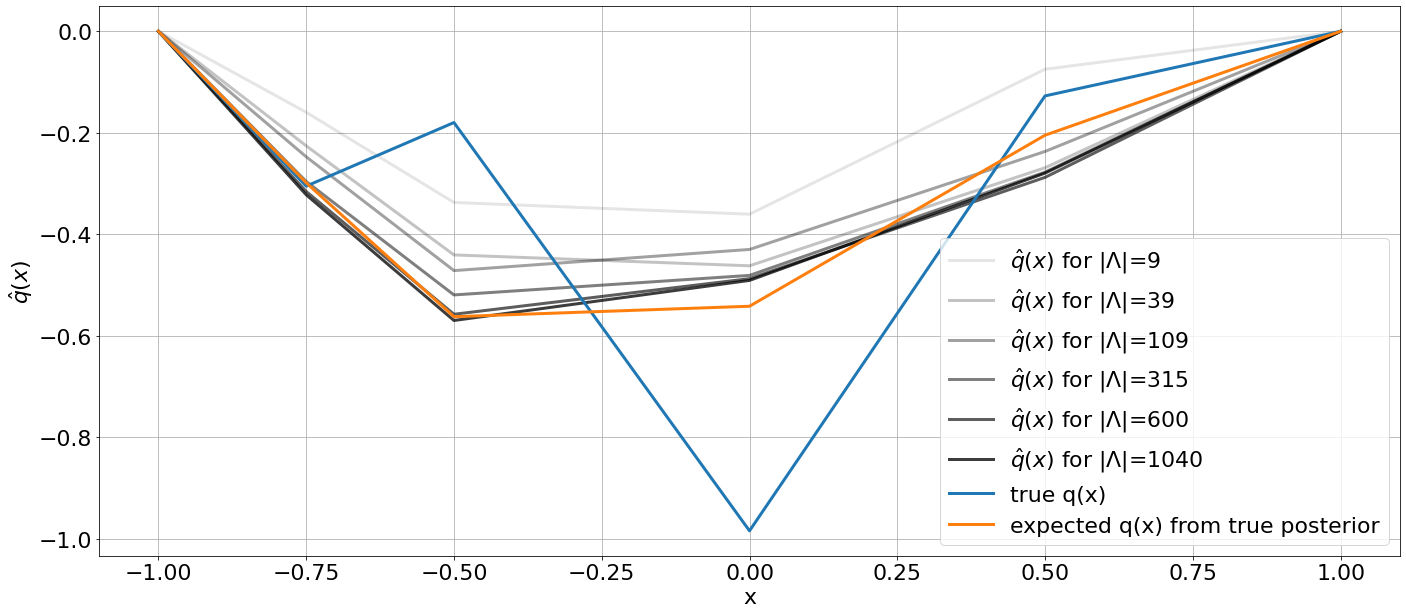

In [123]:
print(p)
q = basis.hats
fig = plt.figure(figsize=(20,9))
ax = plotutil.get_ax(fig, 1, 1, title='', ylabel=r'$\hat{q}(x)$')
for i in range(len(expts)) : 
    ax.plot(x_grid, [q(xi, expts[i], alpha) for xi in x_grid], 'k', alpha=.1+.8*i/len(expts), label=r'$\hat{q}(x)$' + ' for $|\Lambda|$={}'.format(int(lambdas[i])), lw=3)
ax.plot(x_grid, [q(xi, p, alpha) for xi in x_grid], label='true q(x)',  lw=3)
ax.plot(x_grid, [q(xi, expected_p_4, alpha) for xi in x_grid], label='expected q(x) from true posterior',  lw=3)
ax.legend()
plt.tight_layout()

if True :
    filename = '../../overview/figures/alpha={}/expectation_{}d.'.format(alpha, d)
    plt.savefig(filename+'pdf', format='pdf')

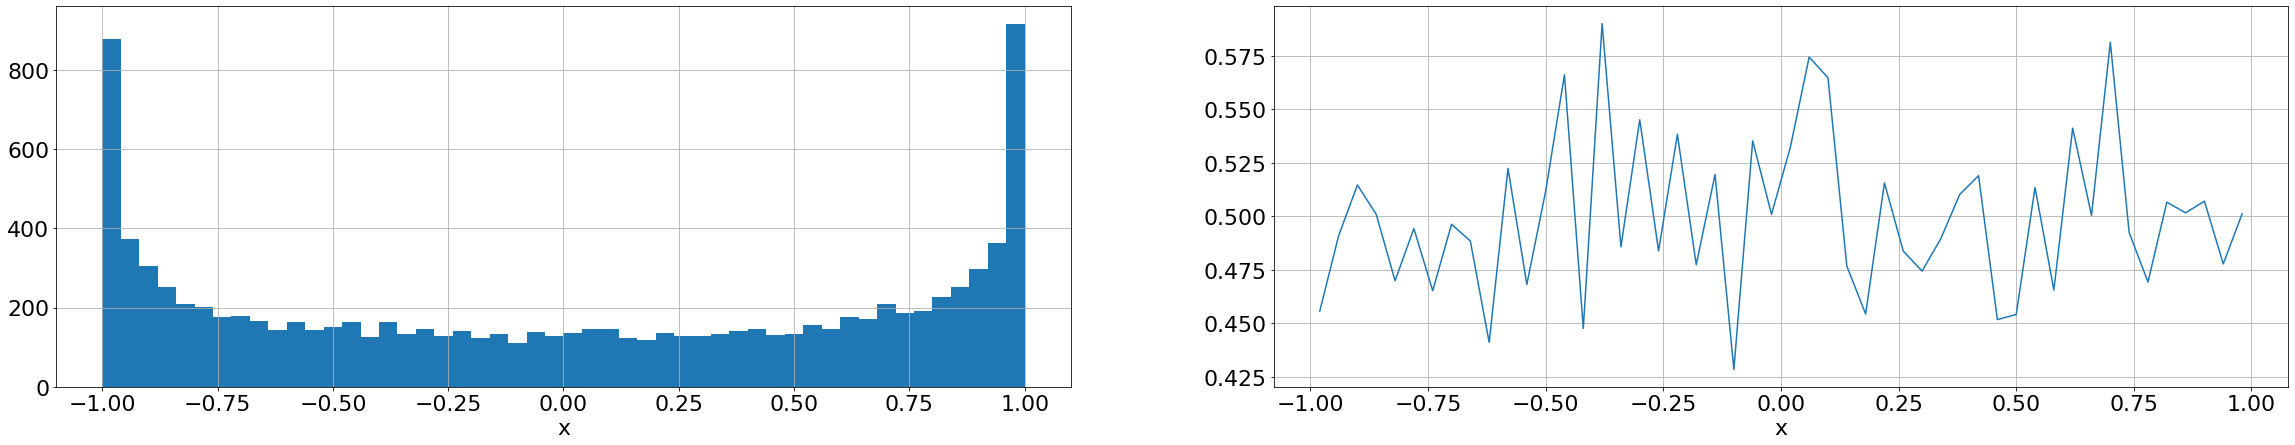

In [31]:
samples = np.sin(np.random.uniform(low=-3*np.pi/2, high=np.pi/2, size=(10000,)))
hist, edges = np.histogram(samples, weights=[np.pi * np.sqrt(1-x**2) / 2 for x in samples], bins=50, density=True )

fig = plt.figure()
ax = plotutil.get_ax(fig, 2, 1)
ax.hist(samples, bins=50)
ax = plotutil.get_ax(fig, 2, 2)
ax.plot((edges[:-1] + edges[1:])/2, hist)
plt.show()